### Load Libraries

In [133]:
import sqlite3
import pandas as pd
#import geopandas as gpd
#from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split # Split data into train and test set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

### Load Data

Data is stored in sqlite.  Pandas library was used to import as dataframe.
Connection is closed after loading to dataframe.

In [115]:
conn = sqlite3.connect(r'C:\Users\17742\OneDrive\Documents\DSC 680\Project 2\FPA_FOD_20170508_1.sqlite')

In [116]:
df = pd.read_sql("""

                SELECT *
                from fires 
                        
                 """, con=conn)

In [117]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [118]:
conn.close()

### Explore the Data

In [119]:
# Check the data type for each variable

df.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

In [120]:
# Check for variables that have missing values.

for c in df.columns:
    missing = df[c].isnull().sum()
    if missing > 0:
        print("{} has {} missing value(s)".format(c, missing))
    else:
        print("{} has NO missing value(s)".format(c, missing))

OBJECTID has NO missing value(s)
FOD_ID has NO missing value(s)
FPA_ID has NO missing value(s)
SOURCE_SYSTEM_TYPE has NO missing value(s)
SOURCE_SYSTEM has NO missing value(s)
NWCG_REPORTING_AGENCY has NO missing value(s)
NWCG_REPORTING_UNIT_ID has NO missing value(s)
NWCG_REPORTING_UNIT_NAME has NO missing value(s)
SOURCE_REPORTING_UNIT has NO missing value(s)
SOURCE_REPORTING_UNIT_NAME has NO missing value(s)
LOCAL_FIRE_REPORT_ID has 1459286 missing value(s)
LOCAL_INCIDENT_ID has 820821 missing value(s)
FIRE_CODE has 1555636 missing value(s)
FIRE_NAME has 957189 missing value(s)
ICS_209_INCIDENT_NUMBER has 1854748 missing value(s)
ICS_209_NAME has 1854748 missing value(s)
MTBS_ID has 1869462 missing value(s)
MTBS_FIRE_NAME has 1869462 missing value(s)
COMPLEX_NAME has 1875282 missing value(s)
FIRE_YEAR has NO missing value(s)
DISCOVERY_DATE has NO missing value(s)
DISCOVERY_DOY has NO missing value(s)
DISCOVERY_TIME has 882638 missing value(s)
STAT_CAUSE_CODE has NO missing value(s)


<AxesSubplot:>

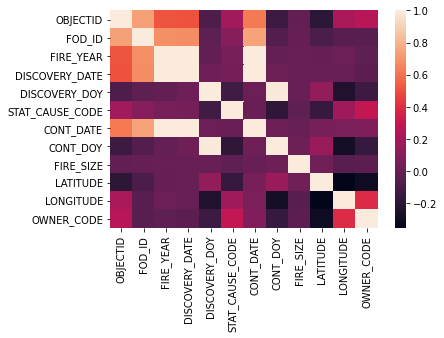

In [121]:
# Create a correlation heatmap of the dataframe
# Identify any multicollinearity

sns.heatmap(df.corr())

In [122]:
# Subset the dataframe with the variables of focus

df1 = df[['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE',
         'STAT_CAUSE_DESCR', 'FIRE_SIZE',
         'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY']]

In [123]:
# Confirm

df1.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY
0,2005,2453403.5,33,9.0,Miscellaneous,0.10,A,40.036944,-121.005833,CA,63
1,2004,2453137.5,133,1.0,Lightning,0.25,A,38.933056,-120.404444,CA,61
2,2004,2453156.5,152,5.0,Debris Burning,0.10,A,38.984167,-120.735556,CA,17
3,2004,2453184.5,180,1.0,Lightning,0.10,A,38.559167,-119.913333,CA,3
4,2004,2453184.5,180,1.0,Lightning,0.10,A,38.559167,-119.933056,CA,3


In [124]:
# Check how many rows and columns

df1.shape

(1880465, 11)

<AxesSubplot:>

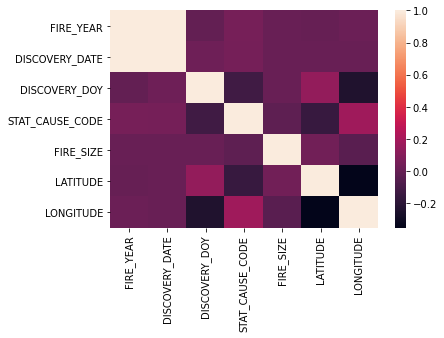

In [125]:
# Create a correlation heatmap of the new dataframe

sns.heatmap(df1.corr())

In [126]:
# Check for variables that have missing values.

for c in df1.columns:
    missing = df1[c].isnull().sum()
    if missing > 0:
        print("{} has {} missing value(s)".format(c, missing))
    else:
        print("{} has NO missing value(s)".format(c, missing))

FIRE_YEAR has NO missing value(s)
DISCOVERY_DATE has NO missing value(s)
DISCOVERY_DOY has NO missing value(s)
STAT_CAUSE_CODE has NO missing value(s)
STAT_CAUSE_DESCR has NO missing value(s)
FIRE_SIZE has NO missing value(s)
FIRE_SIZE_CLASS has NO missing value(s)
LATITUDE has NO missing value(s)
LONGITUDE has NO missing value(s)
STATE has NO missing value(s)
COUNTY has 678148 missing value(s)


In [127]:
# Create a subset with fire sizes larger than 500 acres
# Create a dataframe with fire sizes grouped by their cause

big_fires = df1[df1['FIRE_SIZE']>500]

big_fire_count = pd.DataFrame(
    big_fires.groupby(['STAT_CAUSE_DESCR']).FIRE_SIZE.count().sort_values(ascending=False)).reset_index()

Text(0, 0.5, 'Cause of Fires')

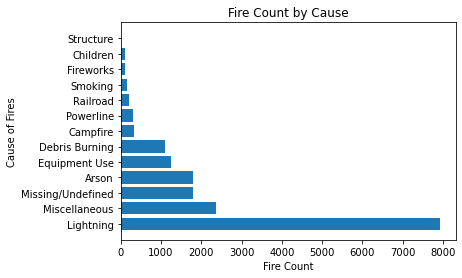

In [128]:
# horizontal bar chart of fire size grouped by cause

plt.barh(big_fire_count['STAT_CAUSE_DESCR'], big_fire_count['FIRE_SIZE'])
plt.title('Fire Count by Cause')
plt.xlabel('Fire Count')
plt.ylabel('Cause of Fires')

In [129]:
# Create a dataframe with fire sizes grouped by year of fire 
# (still focusing on fires larger than 500 acres)

sum_acres = pd.DataFrame(df1.groupby(['FIRE_YEAR']).FIRE_SIZE.sum().reset_index())

Text(0, 0.5, 'Total Acres')

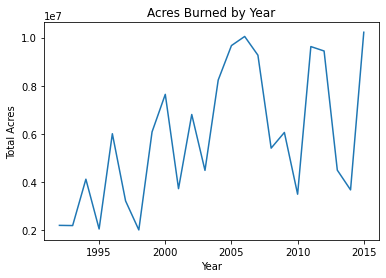

In [130]:
# Line plot of acres burned by year

plt.plot(sum_acres['FIRE_YEAR'], sum_acres['FIRE_SIZE'])
plt.title('Acres Burned by Year')
plt.xlabel('Year')
plt.ylabel('Total Acres')

In [134]:
# Dataframe of count of fires grouped by year

all_fire_count = pd.DataFrame(df1.groupby(['FIRE_YEAR']).FIRE_SIZE.count().reset_index())

Text(0, 0.5, 'Fire Count')

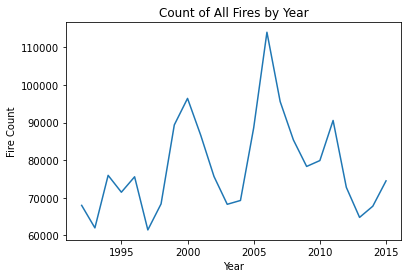

In [136]:
# Line plot of count of fires by year

plt.plot(all_fire_count['FIRE_YEAR'], all_fire_count['FIRE_SIZE'])
plt.title('Count of All Fires by Year')
plt.xlabel('Year')
plt.ylabel('Fire Count')

In [137]:
# Dataframe of how many fires in each fire size class

fire_by_class = pd.DataFrame(df1.groupby(['FIRE_SIZE_CLASS']).FIRE_SIZE.count().reset_index())

Text(0, 0.5, 'Fire Count')

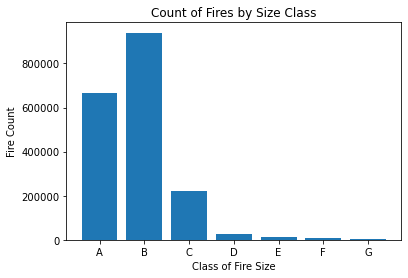

In [138]:
# Fires per Size Class bar plot

plt.bar(fire_by_class['FIRE_SIZE_CLASS'], fire_by_class['FIRE_SIZE'])
plt.title('Count of Fires by Size Class')
plt.xlabel('Class of Fire Size')
plt.ylabel('Fire Count')

In [139]:
# Count of fires by state

fire_by_state = pd.DataFrame(df1.groupby(['STATE']).FIRE_SIZE.count().reset_index())

In [140]:
# A look at the dataframe

fire_by_state.head()

,STATE,FIRE_SIZE
0,AK,12843
1,AL,66570
2,AR,31663
3,AZ,71586
4,CA,189550


In [141]:
# Treemap of number of fires by state
# Exported to PDF 

fig = px.treemap(fire_by_state, path = ['STATE'], values = 'FIRE_SIZE', title = 'Forest Fires by State')
fig.write_image("images/treemap.pdf")

### Modeling

In [236]:
# As we know that fire size and fire size class are dependent, as well as state and county,
# cause code and cause, some of these variables can be removed

df2 = df1[['FIRE_YEAR', 'STAT_CAUSE_CODE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE']]

In [237]:
df2.head()

,FIRE_YEAR,STAT_CAUSE_CODE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE
0,2005,9.0,A,40.036944,-121.005833
1,2004,1.0,A,38.933056,-120.404444
2,2004,5.0,A,38.984167,-120.735556
3,2004,1.0,A,38.559167,-119.913333
4,2004,1.0,A,38.559167,-119.933056


In [238]:
factor = pd.factorize(df2['FIRE_SIZE_CLASS'])
df2['FIRE_SIZE_CLASS'] = factor[0]
definitions = factor[1]
df2['FIRE_SIZE_CLASS'].head()
print(definitions)

Index(['A', 'B', 'G', 'C', 'D', 'F', 'E'], dtype='object')


C:\Users\17742\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [239]:
x = df2[['FIRE_YEAR', 'STAT_CAUSE_CODE', 'LATITUDE', 'LONGITUDE']].values

In [241]:
y = df2['FIRE_SIZE_CLASS'].values

In [244]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify=y, random_state = 21)

In [245]:
# Feature Scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Random Forest Classification

In [246]:
# Fitting Random Forest Classification to the Training set

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [247]:
# Predicting the Test set results

y_pred = classifier.predict(X_test)

#Reverse factorize (converting y_pred to 7 fire class categories

reversefactor = dict(zip(range(7),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)

# Making the Confusion Matrix

print(pd.crosstab(y_test, y_pred, rownames=['Actual Fire Class'], colnames=['Predicted Fire Class']))

Predicted Fire Class       A       B      C    D    E    F    G
Actual Fire Class                                              
A                     111797   51022   3283  304  163  113   48
B                      58404  158849  15908  956  435  189  103
C                       7507   35176  10979  848  316  124   69
D                       1274    3522   1635  395  161   84   36
E                        804    1516    687  222  161   96   41
F                        553     707    323   95  103   93   73
G                        311     329    119   35   29   49   71


In [248]:
confusion_matrix(y_test, y_pred)

array([[111797,  51022,   3283,    304,    163,    113,     48],
       [ 58404, 158849,  15908,    956,    435,    189,    103],
       [  7507,  35176,  10979,    848,    316,    124,     69],
       [  1274,   3522,   1635,    395,    161,     84,     36],
       [   804,   1516,    687,    222,    161,     96,     41],
       [   553,    707,    323,     95,    103,     93,     73],
       [   311,    329,    119,     35,     29,     49,     71]],
      dtype=int64)

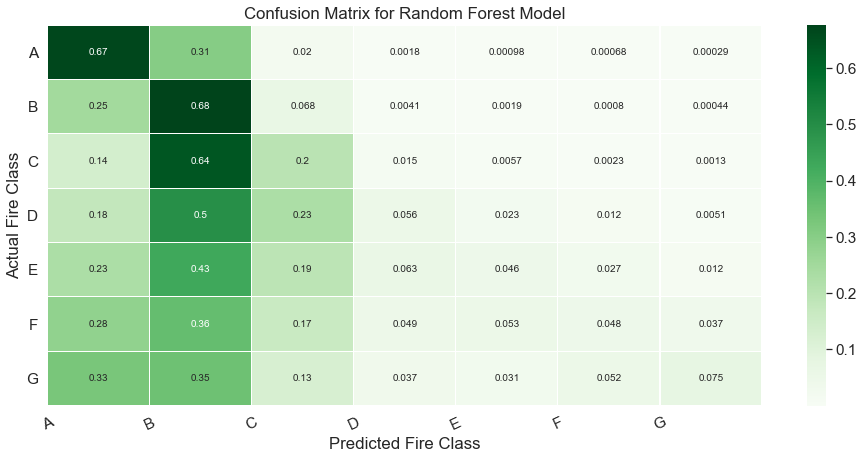

In [249]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['A', 'B', 'C', 
               'D', 'E', 'F',    
               'G']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted Fire Class')
plt.ylabel('Actual Fire Class')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [250]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.62      0.67      0.64    166730
           B       0.63      0.68      0.65    234844
           C       0.33      0.20      0.25     55019
           D       0.14      0.06      0.08      7107
           E       0.12      0.05      0.07      3527
           F       0.12      0.05      0.07      1947
           G       0.16      0.08      0.10       943

    accuracy                           0.60    470117
   macro avg       0.30      0.25      0.27    470117
weighted avg       0.58      0.60      0.59    470117



#### K Nearest Neighbor Classification

In [284]:
knn = KNeighborsClassifier(n_neighbors=15)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify=y, random_state = 21)

In [286]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [287]:
# Predict on dataset which model has not seen before
print(knn.predict(X_test))
# Calculate the accuracy of the model
print(knn.score(X_test, y_test))

[1 0 0 ... 1 1 0]
0.6215665462002012


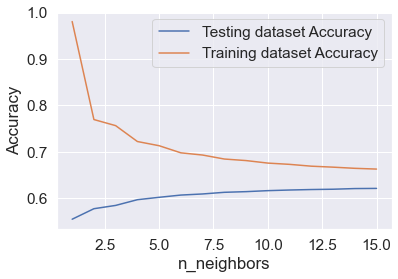

In [288]:
neighbors = np.arange(1, 16)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot

plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

#### Gradient Boosting Classification

In [274]:
x = df2[['FIRE_YEAR', 'STAT_CAUSE_CODE', 'LATITUDE', 'LONGITUDE']].values

In [275]:
y = df2['FIRE_SIZE_CLASS'].values

In [281]:
kf = KFold(n_splits=10,random_state=42,shuffle=True)
for train_index,val_index in kf.split(x):
    X_train,X_val = x[train_index],x[val_index],
    y_train,y_val = y[train_index],y[val_index]

In [282]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [283]:
gradient_booster.fit(X_train,y_train)
print(classification_report(y_val,gradient_booster.predict(X_val)))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61     66758
           1       0.60      0.79      0.68     93910
           2       0.38      0.06      0.11       382
           3       0.32      0.00      0.00     21997
           4       0.00      0.00      0.00      2845
           5       0.13      0.00      0.01       775
           6       1.00      0.00      0.00      1379

    accuracy                           0.61    188046
   macro avg       0.44      0.21      0.20    188046
weighted avg       0.57      0.61      0.56    188046

